In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
from pinns.prelude import *
from pinns.domain import Sphere
from pinns.krr import krr, rbf
from pinns.pde import poisson_dirichlet_qp, poisson_dirichlet_ecqp
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(10))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(8))
x_bnd = domain.transform_bnd(x_bnd)


In [5]:
def mag(x):
    return array([0., 0., 1.])


def phi2_solution(x, x_bnd):
    eps = 1e-7
    def g(y):
        n = y / norm(y, axis=-1)
        return dot(mag(y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (4 * pi * 1. ** 2) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)



def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)


def plot_model(model):
    fig = plt.figure(figsize=(8, 3))
    ax1, ax2 = fig.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax1)
    ax1.set_title("Model")    
    plot_result(lambda x: (model(x) - x[..., 2] / 3) ** 2, ax2)
    ax2.set_title("Squared error")


In [6]:
_x_bnd = array(Sobol(2, seed=123).random_base2(15))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [7]:
X = concatenate([x_bnd, x_dom])
u = lambda x: rbf(x, x_dom, gamma=0.1)

coef = poisson_dirichlet_ecqp(u, lambda x: 0, x_dom, x_bnd, phi_bnd,     
    refine_regularization=0.5, refine_maxiter=10).params.primal

model = vmap(lambda x: coef @ u(x))

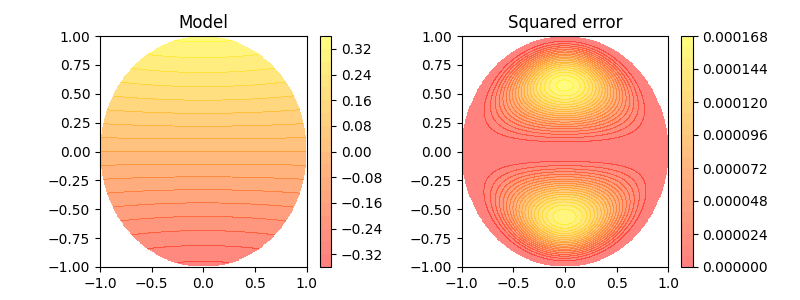

In [8]:
plot_model(model)

In [24]:
X = concatenate([x_bnd, x_dom])
l = lambda x: (1 - norm(x, axis=-1) ** 2)
u = lambda x: l(x) * rbf(x, x_dom, gamma=0.1)
g = krr(partial(rbf, gamma=0.1), x_bnd, phi_bnd, alpha=0.01)
params = poisson_dirichlet_qp(u, g, lambda x: 0, x_dom, ridge=0.1)
model = vmap(lambda x: g(x) + u(x) @ params)

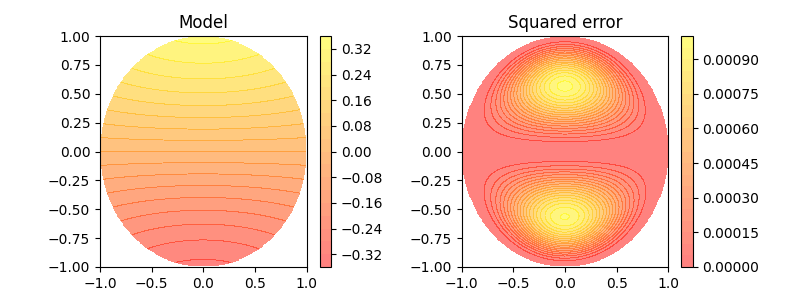

In [25]:
plot_model(model)

In [11]:
#ELM
weights = array(Sobol(4, seed=12345).random_base2(5))
W = weights[:, :3] * 2 - 1
b = weights[:, 3] * 2 - 1
u = lambda x: tanh(W @ x + b)

In [12]:
coef = poisson_dirichlet_ecqp(u, lambda x: 0, x_dom, x_bnd, phi_bnd,     
     refine_regularization=0.5, refine_maxiter=30, maxiter=5000, tol=1e-10
).params.primal

model = vmap(lambda x: coef @ u(x))

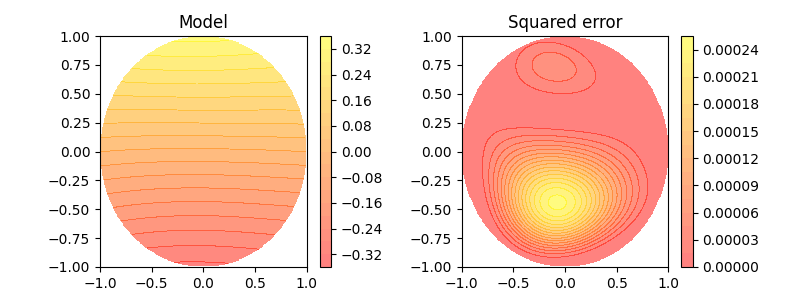

In [13]:
plot_model(model)

In [14]:
from jaxopt.linear_solve import solve_normal_cg
from dataclasses import dataclass, field

@dataclass(frozen=True)
class ELM:
    coef: ndarray
    W: ndarray
    b: ndarray
    activation: Callable = field(compare=False)

    def __call__(self, x):
        return self.activation(x @ self.W.T + b) @ self.coef
        

def elm(X, y, W, b, activation=tanh, init=None, **solver_kwargs):
    slp = vmap(lambda x: activation(W @ x + b))
    H = slp(X)
    if init is None and len(y.shape) == 1:
        init = tree_map(lambda W: zeros((W.shape[0],)), W)
    elif init is None and len(y.shape) > 1:
        init = tree_map(lambda W, y: zeros((W.shape[0], y.shape[-1])), W, y)
    p = solve_normal_cg(lambda x: H @ x, y, init=init, **solver_kwargs)
    return ELM(p, W, b, activation)

In [15]:
weights = array(Sobol(4, seed=12345).random_base2(4))
W = weights[:, :3] * 2 - 1
b = weights[:, 3] * 2 - 1
l = lambda x: (1 - norm(x, axis=-1) ** 2)
u = lambda x: l(x) * tanh(W @ x + b)
g = elm(x_bnd, phi_bnd, W, b)


X = concatenate([x_bnd, x_dom])
params = poisson_dirichlet_qp(u, g, lambda x: 0, x_dom)
model = vmap(lambda x: g(x) + u(x) @ params)

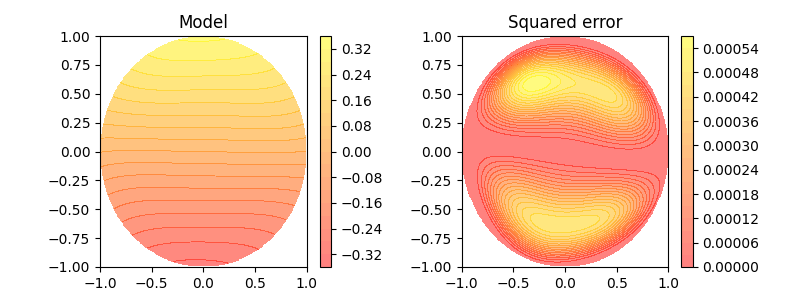

In [16]:
plot_model(model)

In [17]:
g(x_bnd).shape

(256,)